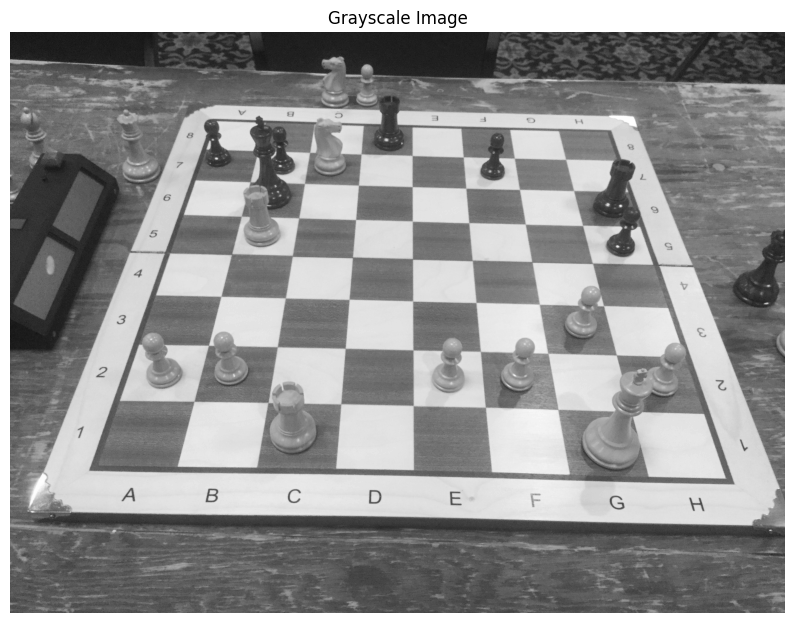

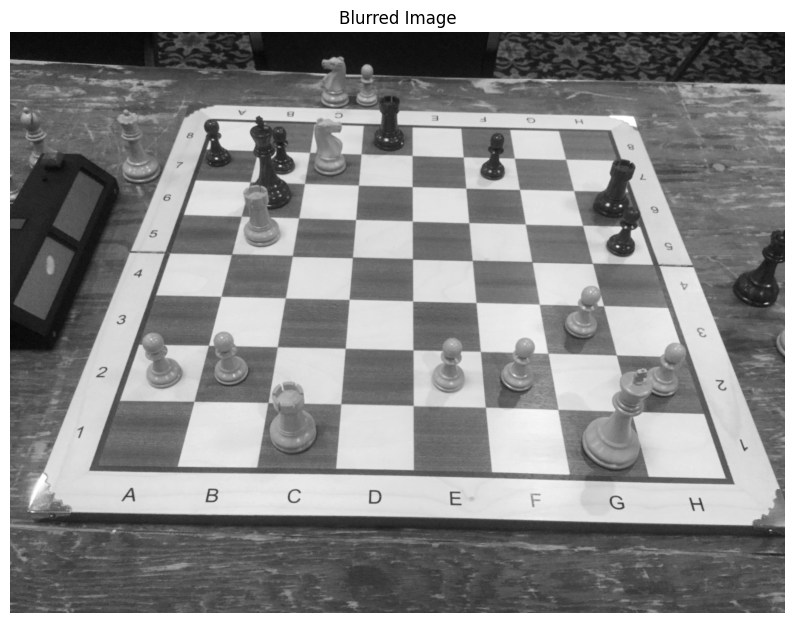

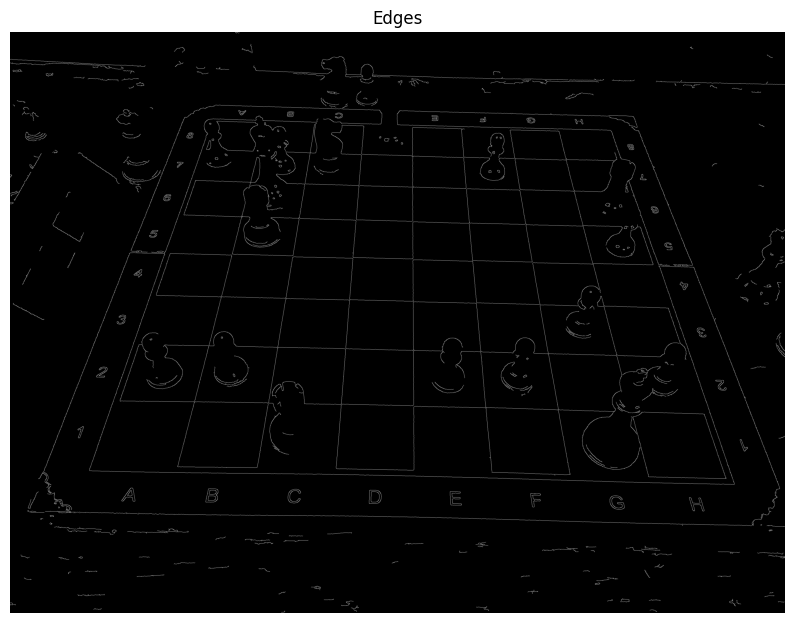

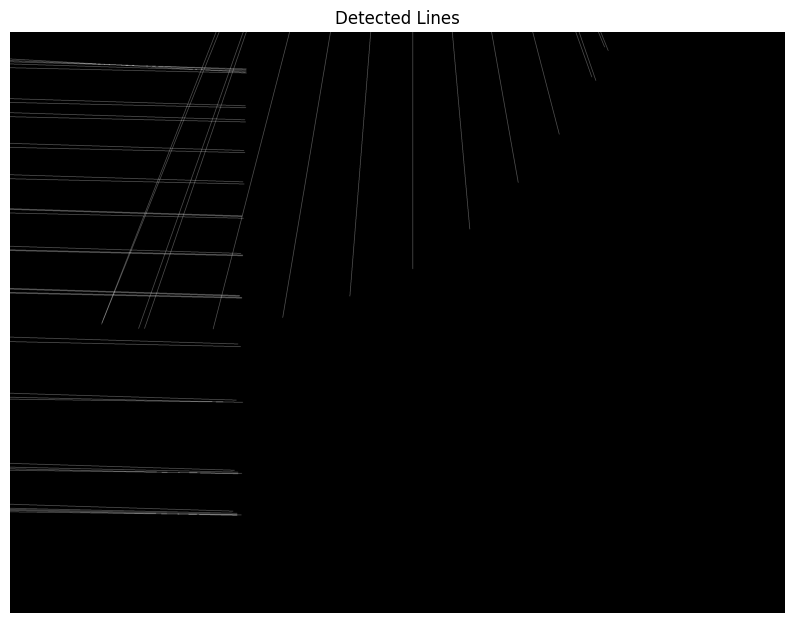

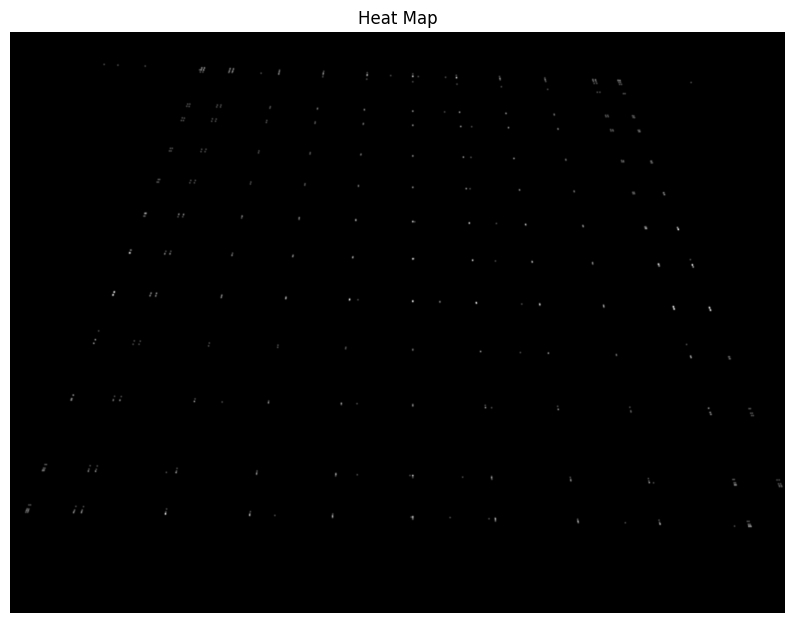

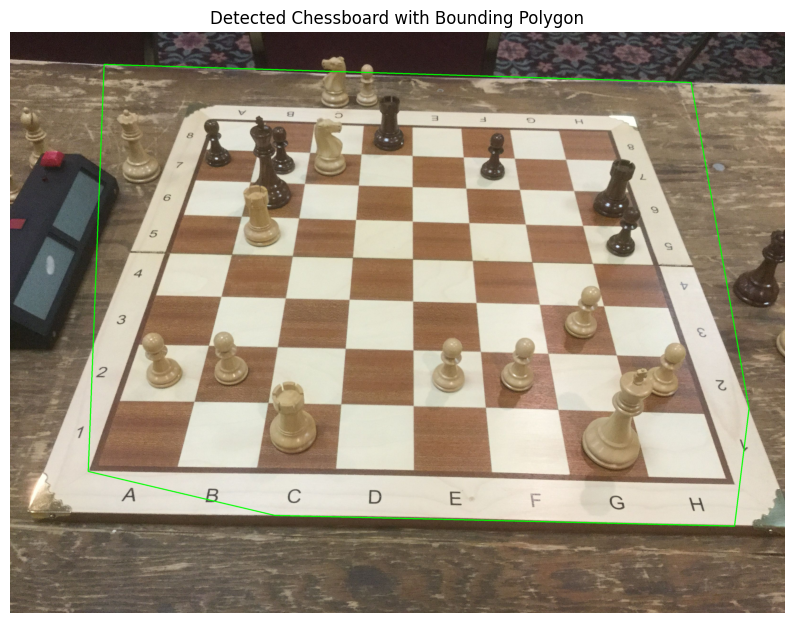

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def display_image(img, title="Image"):
    """Utility function to display an image."""
    plt.figure(figsize=(10, 8))
    if len(img.shape) == 2:  # Grayscale image
        plt.imshow(img, cmap='gray')
    else:  # Color image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detect_and_draw_lines(image, edges, rho, theta, threshold):
    """
    Function to detect and draw lines using the Hough Transform.
    """
    lines = cv2.HoughLines(edges, rho, theta, threshold)
    if lines is not None:
        line_img = np.zeros_like(image)
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 255, 255), 1)
        return line_img, lines
    else:
        return None, None

def calculate_heat_map(lattice_points, image_shape):
    """
    Generate a heat map based on detected lattice points.
    """
    heat_map = np.zeros(image_shape[:2], dtype=np.float32)
    for point in lattice_points:
        heat_map[point[1], point[0]] += 1  # Increment heat at lattice point positions
    
    # Apply Gaussian blur to create smoother heat map
    heat_map = cv2.GaussianBlur(heat_map, (15, 15), 0)
    return heat_map

def cluster_lattice_points(lattice_points):
    """
    Cluster lattice points to identify the chessboard region.
    """
    # Convert to a NumPy array for clustering
    points = np.array(lattice_points)

    # DBSCAN clustering
    clustering = DBSCAN(eps=20, min_samples=5).fit(points)  # Tune `eps` and `min_samples` as needed
    labels = clustering.labels_

    # Filter points belonging to the largest cluster
    largest_cluster = max(set(labels), key=list(labels).count)
    clustered_points = points[labels == largest_cluster]

    return clustered_points

def locate_chessboard_boundary(clustered_points):
    """
    Locate the bounding polygon around the clustered points.
    """
    # Convert points to the required shape for cv2 functions
    clustered_points = np.array(clustered_points, dtype=np.int32)

    # Find the convex hull of the clustered points
    hull = cv2.convexHull(clustered_points)
    return hull


def process_image(input_path):
    # Load the input image
    image = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError("Image not found. Please check the path.")

    # Step 1: Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    display_image(gray_image, "Grayscale Image")

    # Step 2: Apply Gaussian Blur (helps reduce noise)
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    display_image(blurred, "Blurred Image")

    # Step 3: Apply Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    display_image(edges, "Edges")

    # Step 4: Detect lines using Hough Transform
    rho = 1
    theta = 0.0087
    threshold = 300
    line_img, lines = detect_and_draw_lines(gray_image, edges, rho, theta, threshold)
    if line_img is not None:
        display_image(line_img, "Detected Lines")
    else:
        print("No lines detected.")
        return

    # Step 5: Detect lattice points as intersections of lines
    lattice_points = []
    if lines is not None:
        height, width = gray_image.shape
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                rho1, theta1 = lines[i][0]
                rho2, theta2 = lines[j][0]
                det = np.sin(theta1) * np.cos(theta2) - np.sin(theta2) * np.cos(theta1)
                if abs(det) > 1e-5:  # Avoid parallel lines
                    x = (rho2 * np.sin(theta1) - rho1 * np.sin(theta2)) / det
                    y = (rho1 * np.cos(theta2) - rho2 * np.cos(theta1)) / det

                    # Add boundary check
                    if 0 <= x < width and 0 <= y < height:
                        lattice_points.append((int(x), int(y)))

    # Step 6: Generate heat map
    if lattice_points:
        heat_map = calculate_heat_map(lattice_points, gray_image.shape)
        display_image(heat_map, "Heat Map")

        # Step 7: Cluster lattice points and locate chessboard
        if lattice_points:
            clustered_points = cluster_lattice_points(lattice_points)
            if clustered_points.size > 0:
                hull = locate_chessboard_boundary(clustered_points)

                # Draw the convex hull on the original image
                cv2.drawContours(image, [hull], 0, (0, 255, 0), 3)
                display_image(image, "Detected Chessboard with Bounding Polygon")
            else:
                print("No clusters found.")
        else:
            print("No lattice points detected.")


# Usage
input_path = "../data/chessboard.jpeg"  # Replace with your image path
process_image(input_path)
